# Stellar benchmark

Comparison between fit results from the ``apollinaire`` code and those published in Lund et al. 2017.

In [1]:
from aux import *
import apollinaire as apn

In [2]:
dr25 = pd.read_csv ('tables/dr25.csv')
dr25 = dr25.set_index ('KIC')

df_ref = pd.read_csv ('tables/lund_2017.csv', index_col=0)
df_ref = df_ref.loc[df_ref['KIC']!=df_ref['KIC'].iloc[-1]]
df_ref['KIC'] = df_ref['KIC'].map (np.int_)
df_ref.columns

Index(['KIC', 'n', 'l', 'Freq', 'e_Freq', 'e_freq_lc', 'Amp', 'e_Amp',
       'e_amp_lc', 'Width', 'e_Width', 'e_width_lc', 'l_lnK', 'lnK'],
      dtype='object')

In [3]:
list_kic = [6603624, 5184732, 6106415, 6225718, 12069449, 12069424]
list_kic.sort ()
print (dr25.loc[list_kic, ['Teff', 'log_g_', '__Fe_H_', 'Rad', 'Mass']].sort_index ().to_latex ())

\begin{tabular}{lrrrrr}
\toprule
{} &  Teff &  log\_g\_ &  \_\_Fe\_H\_ &    Rad &   Mass \\
KIC      &       &         &          &        &        \\
\midrule
5184732  &  5835 &   4.257 &     0.36 &  1.326 &  1.159 \\
6106415  &  6028 &   4.295 &    -0.04 &  1.202 &  1.039 \\
6225718  &  6320 &   4.316 &    -0.08 &  1.207 &  1.096 \\
6603624  &  5671 &   4.319 &     0.28 &  1.162 &  1.027 \\
12069424 &  5775 &   4.294 &     0.02 &  1.165 &  0.973 \\
12069449 &  5745 &   4.359 &     0.00 &  1.069 &  0.952 \\
\bottomrule
\end{tabular}



KIC 5184732: 26 fitted modes, 3 modes beyond 1 sigma, 0 modes beyond 3 sigma
KIC 6106415: 25 fitted modes, 2 modes beyond 1 sigma, 0 modes beyond 3 sigma
KIC 6225718: 24 fitted modes, 7 modes beyond 1 sigma, 0 modes beyond 3 sigma
KIC 6603624: 26 fitted modes, 6 modes beyond 1 sigma, 1 modes beyond 3 sigma
KIC 12069424: 26 fitted modes, 10 modes beyond 1 sigma, 0 modes beyond 3 sigma
KIC 12069449: 27 fitted modes, 11 modes beyond 1 sigma, 2 modes beyond 3 sigma
Summary: 154 fitted modes, 39 modes beyond 1 sigma, 3 modes beyond 3 sigma


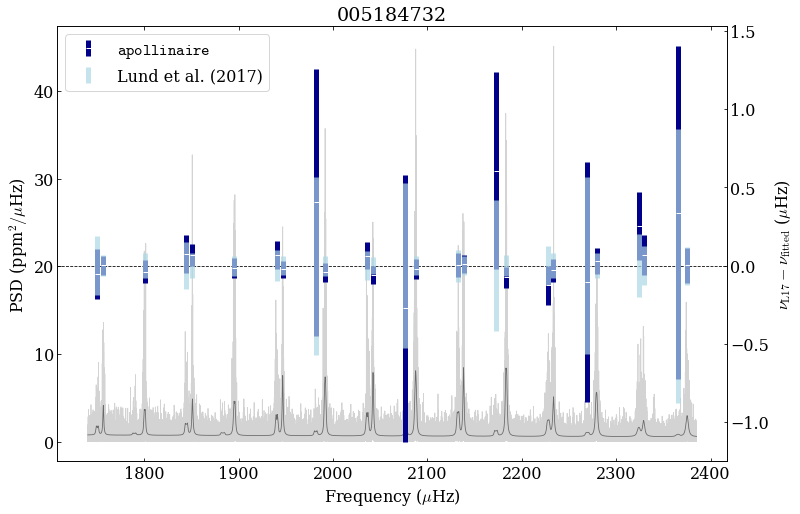

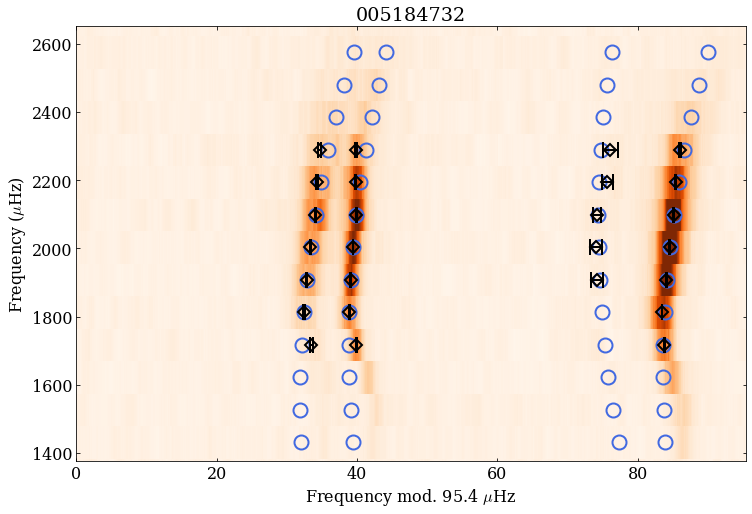

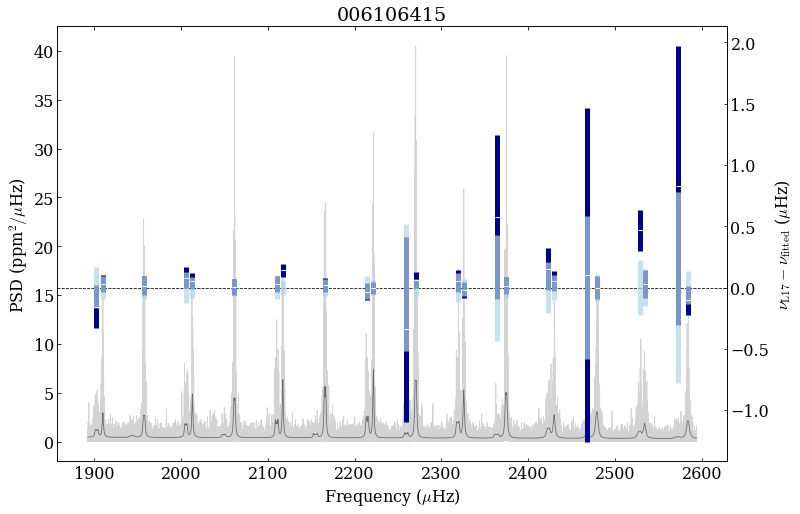

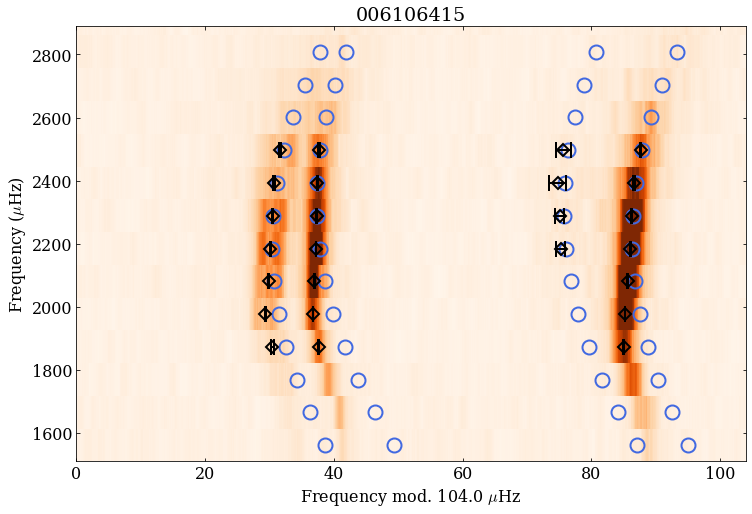

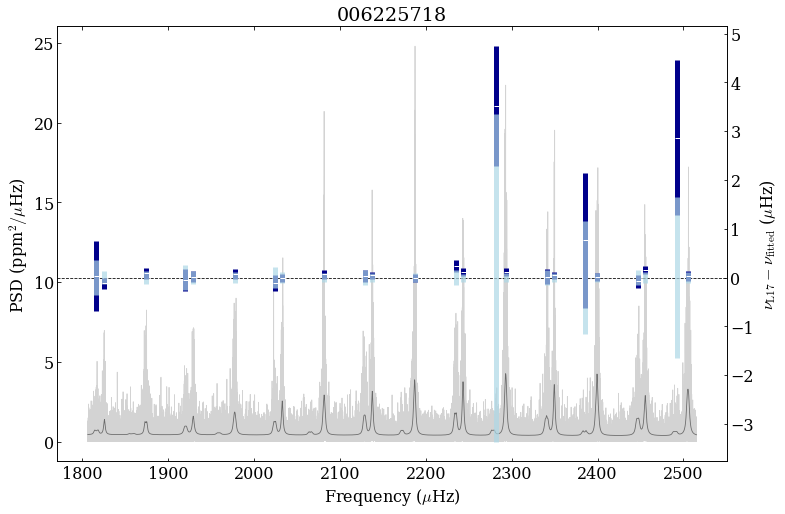

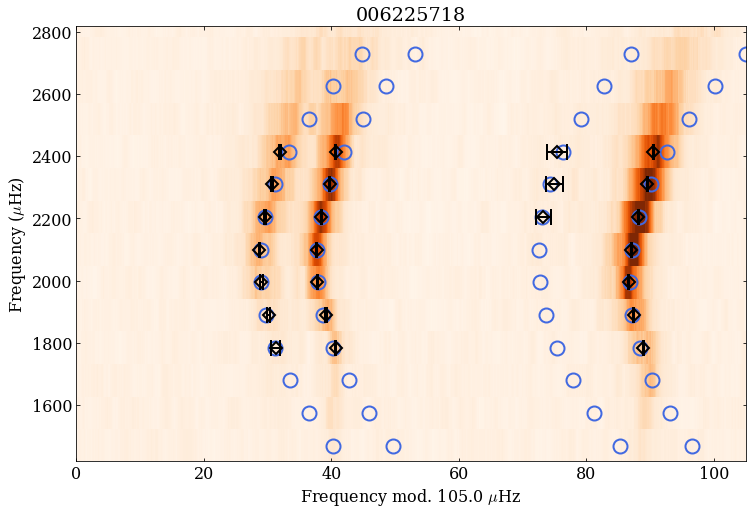

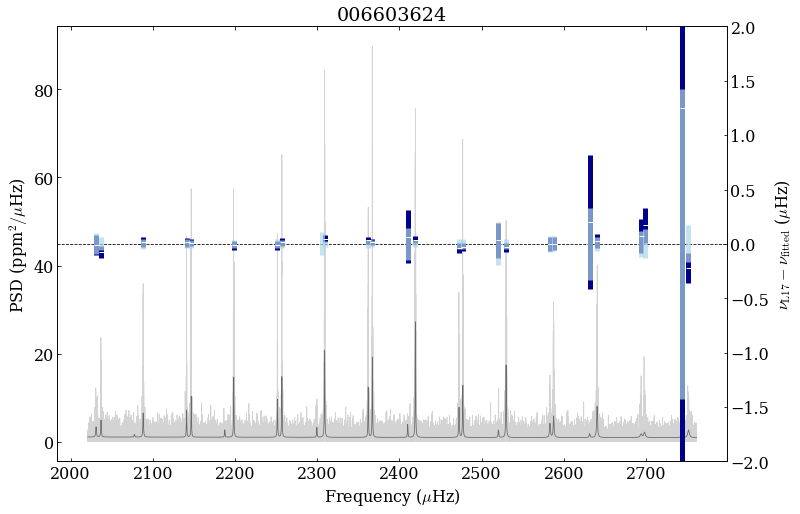

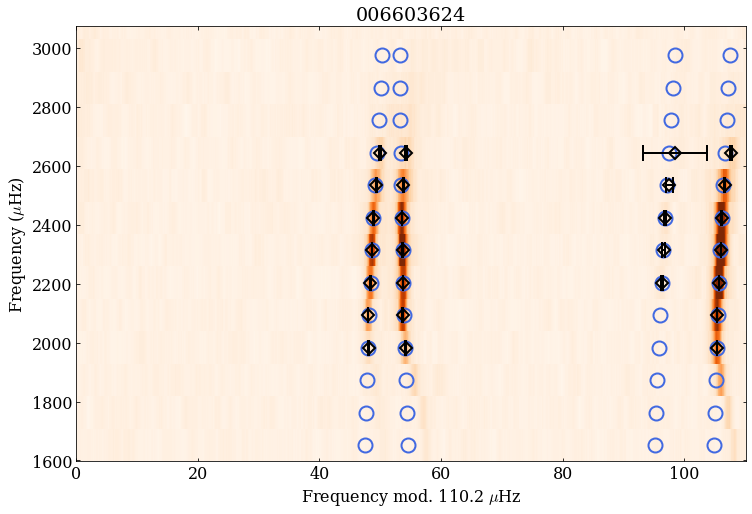

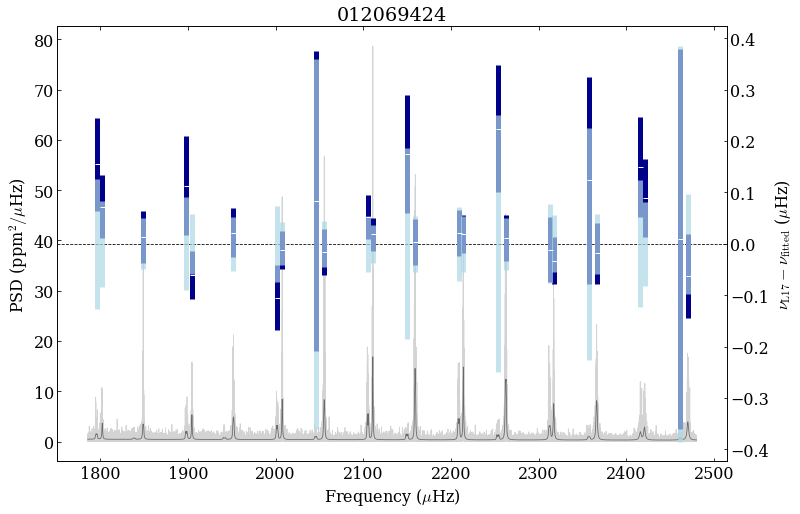

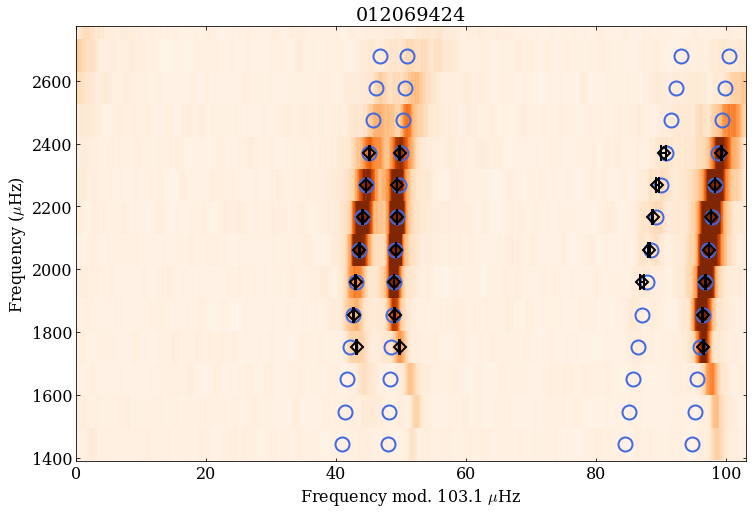

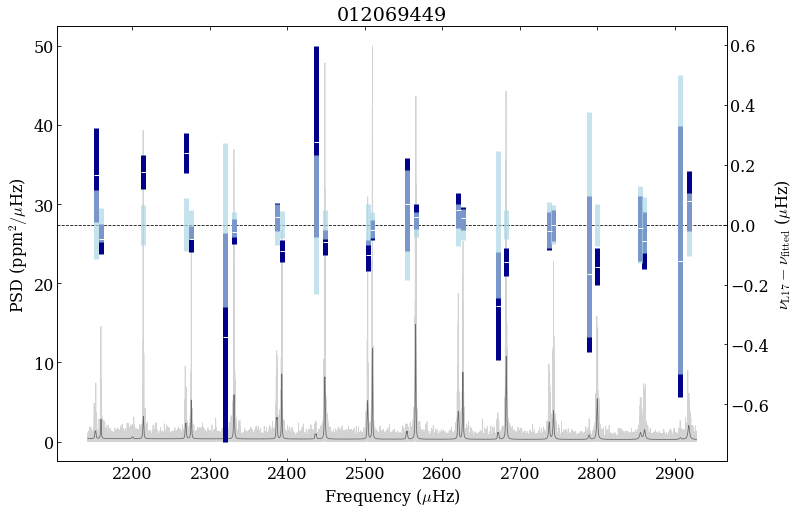

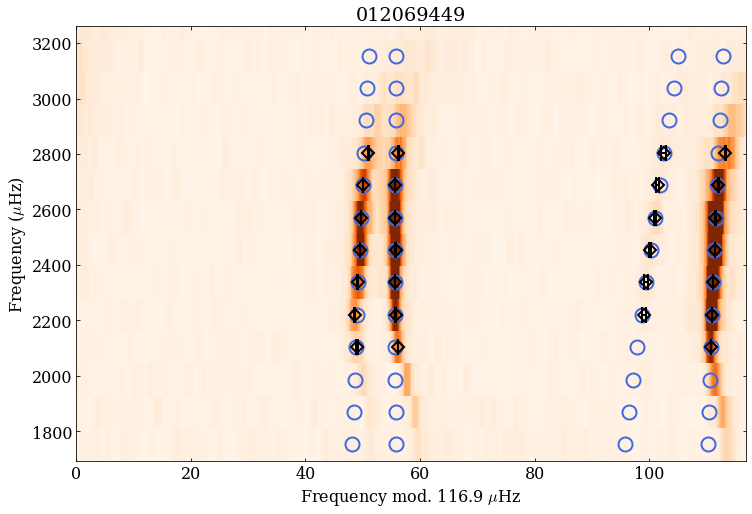

In [5]:
full = pd.DataFrame ()
nmodes, total_one_sigma, total_three_sigma = 0, 0, 0
markers = ['X', 'h', 'd', 'v', 'o', 'p']
comp_freq_qf = np.array ([])

for ii, kic in enumerate (list_kic) :
    
    resDir = str (kic).zfill (9)

    filename = glob.glob (path.join ('data/kplr' + str(kic).zfill (9) + '*_COR_filt_inp.fits'))[0]
    hdu = fits.open (filename) [0]
    data = np.array (hdu.data)
    t = data[:,0]
    v = data[:,1]
    dt = np.median (t[1:] - t[:-1]) * 86400
    freq, psd = apn.psd.series_to_psd (v, dt=dt, correct_dc=True)
    freq = freq*1e6
    psd = psd*1e-6
    
    param_back = np.loadtxt (path.join (resDir, 'background_parameters.dat'), usecols=0)
    back = apn.peakbagging.build_background (freq, param_back)
    pattern = np.loadtxt (path.join (resDir, 'pattern.dat'), usecols=0)
        
    subdf = df_ref.loc[df_ref['KIC']==kic]
    subdf = subdf.set_index (['n', 'l'])
    my_res = read_pkb (path.join (resDir, 'modes_param.pkb'))
    pkb_qf = read_pkb (path.join (resDir + '_quickfit', 'modes_param.pkb'))
    
    
    model = apn.peakbagging.compute_model (freq, my_res.reset_index ().to_numpy ()) + back

    new_index = np.intersect1d (subdf.index, my_res.index) 
    
    my_res = my_res.loc[new_index]
    pkb_qf = pkb_qf.loc[new_index]
    subdf = subdf.loc[new_index]
    
    quality = pd.DataFrame (data=np.loadtxt (path.join (resDir, 'quality_assurance.dat')))
    quality[0] = quality[0].map (np.int_)
    quality[1] = quality[1].map (np.int_)
    quality = quality.set_index ([0, 1])
    quality.index = quality.index.rename (['n', 'l'])
    quality.loc[quality[2]>6, 2] = 6
    quality = quality.rename (columns={2:'lnK apollinaire'})
    my_res = my_res.join (quality)
    
    qf_check = (my_res[2] - pkb_qf[2]) / np.sqrt (np.maximum (my_res[3], my_res[4])**2 + np.maximum (pkb_qf[3], pkb_qf[4])**2)
    qf_check = qf_check.to_numpy ()
    comp_freq_qf = np.append (comp_freq_qf, qf_check)


    compare = subdf.join (my_res)
    
    full = pd.concat ([full, compare])

    figure, ax1 = plt.subplots (1, 1, figsize=(12, 8))
    
    ax = ax1.twinx ()
    ax.axhline (0, linestyle='--', color='black')

    blow, bhigh = (np.amin (compare['Freq']) - 10, np.amax (compare['Freq']) + 10)
    ax1.plot (freq[(freq>blow)&(freq<bhigh)], psd[(freq>blow)&(freq<bhigh)], color='lightgrey')
    ax1.plot (freq[(freq>blow)&(freq<bhigh)], model[(freq>blow)&(freq<bhigh)], color='dimgray')
    
    metric = 1
    if metric==1 :
        ax.errorbar (compare['Freq'], compare['Freq'] - compare[2], yerr=compare[3], color='white', fmt=r'_',
                     capsize=None, elinewidth=5., markersize=5, ecolor='darkblue', label=r'$\mathtt{apollinaire}$')
        ax.errorbar (compare['Freq'], compare['Freq'] - compare['Freq'], yerr=compare['e_Freq'], color='lightblue', fmt='none', 
                     capsize=None, elinewidth=5., alpha=0.7, label='Lund et al. (2017)')
        ax.set_ylabel (r'$\nu_\mathrm{L17} - \nu_\mathrm{fitted}$ ($\mu$Hz)')
        if kic==5184732 :
            ax.legend (loc=2)
        if kic==6603624 :
            ax.set_ylim (-2, 2)
            
    if metric==2 :
        ax.scatter (compare['Freq'], (compare['Freq'] - compare[2]) / (compare[3]**2+compare['e_Freq'])**(1/2), 
                    color='darkblue', s=30, marker='x')
        ax.set_ylabel (r'$\frac {\nu_\mathrm{L17} - \nu_\mathrm{apn}}{\sigma_\mathrm{L17}^2 + \sigma_\mathrm{apn}^2}$ ')
    ax1.set_ylabel (r'PSD (ppm$^2/\mu$Hz)')
    ax1.set_xlabel (r'Frequency ($\mu$Hz)')
    ax.set_title (str(kic).zfill (9))

    
    figure.savefig (path.join ('plots', resDir + '.pdf'), format='pdf')
        
    nu_ref = subdf['Freq'].to_numpy ()
    nu_err = np.maximum (subdf['e_Freq'].to_numpy(), subdf['e_freq_lc'].to_numpy())
    
    my_nu  = my_res[2].to_numpy ()
    my_err = my_res[3].to_numpy ()
    nu_qf = pkb_qf[2].to_numpy ()
    err_qf =  pkb_qf[3].to_numpy ()
    
    
    count_one_sigma = np.count_nonzero ((nu_ref<my_nu-my_err)|(nu_ref>my_nu+my_err))
    count_three_sigma = np.count_nonzero ((nu_ref<my_nu-3*my_err)|(nu_ref>my_nu+3*my_err))
    nmodes += my_nu.size
    total_one_sigma += count_one_sigma
    total_three_sigma += count_three_sigma
    print ('KIC {}: {} fitted modes, {} modes beyond 1 sigma, {} modes beyond 3 sigma'.format (kic, my_nu.size, count_one_sigma, count_three_sigma))
    

    # Preparing the pattern guess overplot
    n = my_res.reset_index().loc[my_res.reset_index()['l']==0, 'n']
    orders = np.arange (np.amin (n)-4, 
                        np.amax (n)+4)
    pkb_pattern = apn.peakbagging.pattern_to_pkb (*pattern, split=0, angle=90, 
                                                  orders=orders, fast=True,
                                                  amp_l=np.array ([1., 1.5, 0.7, 0.2]))

    add_qf = False
    if add_qf :
        scatter_color=['grey', 'brown', 'black']
        fmt=['o', 's', 'x']
        mode_freq = (pkb_pattern[:,2], nu_qf, my_nu)
        mode_freq_err = (None, err_qf, my_err)
        mfc = ('none', 'yellow', 'none')
        ms = [8, 8, 14]
    else :
        scatter_color=['royalblue', 'black']
        fmt=['o', 'D']
        mode_freq = (pkb_pattern[:,2], my_nu)
        mode_freq_err = (None, my_err)
        mfc = ('none', 'none')
        ms = [14, 8] 
    
    dnu = np.mean (np.diff (my_res.reset_index().loc[my_res.reset_index()['l']==0, 2]))
    
    #ylim = (np.amin (nu_ref) - dnu, np.amax (nu_ref))
    ylim = (pkb_pattern[0,2], pkb_pattern[-1,2])
    cmap = 'Oranges'

    freq_pattern = pkb_pattern[pkb_pattern[:,1]==0,2]
    fig = apn.psd.echelle_diagram (freq, psd/back, dnu, twice=False, 
                                   figsize=(12,8), title=str(kic).zfill (9),
                                   smooth=100, cmap=cmap, 
                                   mode_freq=mode_freq, 
                                   mode_freq_err=mode_freq_err,
                                   vmin=None, vmax=10, scatter_color=scatter_color, 
                                   fmt=fmt, ylim=ylim, mew=2., 
                                   ms=ms, mfc=mfc,
                                   capsize=8, elinewidth=2, shading='auto')
    
    fig.savefig (path.join ('plots', 'ed_' + resDir + '.png'), format='png')
    
    #break

print ('Summary: {} fitted modes, {} modes beyond 1 sigma, {} modes beyond 3 sigma'.format (nmodes, 
                                                            total_one_sigma, total_three_sigma))

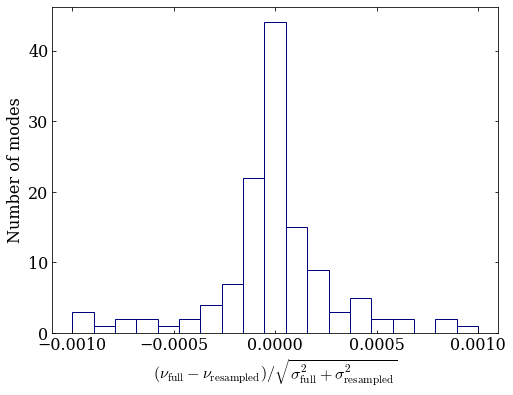

In [6]:
fig, ax = plt.subplots (1, 1, figsize=(8, 6))
ax.hist (comp_freq_qf, edgecolor='navy', facecolor='none',
         bins=np.linspace(-0.001, 0.001, 20))

ax.set_xticks ([-0.001, -0.0005, 0, 0.0005, 0.001])

ax.set_xlabel (r'$(\nu_\mathrm{full} - \nu_\mathrm{resampled}) / \sqrt{\sigma_\mathrm{full}^2 + \sigma_\mathrm{resampled}^2}$')
ax.set_ylabel (r'Number of modes')

plt.savefig ('plots/comparison_quickfit_noquickfit.pdf')

In [7]:
def format_result (full) :
    
    full ['Amp_apn'] = np.sqrt (np.pi * full[6] * full[4] / 2)
    full ['e_Amp_apn'] = np.sqrt (np.pi * full[6] * (full[4] + full[5]) / 2) - full['Amp_apn']
    full ['e_Freq'] = np.maximum (full['e_Freq'], full['e_freq_lc'])
    full ['e_Amp'] = np.maximum (full['e_Amp'], full['e_amp_lc'])
    full ['e_Width'] = np.maximum (full['e_Width'], full['e_width_lc'])
    restriction_freq = ['KIC', 'Freq', 'e_Freq', 'l_lnK', 'lnK', 2, 3, 'lnK apollinaire']
    freq_summary = full[restriction_freq]
    freq_summary = freq_summary.reset_index ()
    freq_summary = freq_summary.set_index ('KIC')
    
    restriction_hw = ['KIC', 'Amp', 'Freq', 'e_Amp', 'Width',  'e_Width', 'Amp_apn', 'e_Amp_apn', 6, 7]
    hw_summary = full[restriction_hw]
    hw_summary = hw_summary.reset_index ()
    hw_summary = hw_summary.set_index ('KIC')
    hw_summary = hw_summary.loc[hw_summary['l']==0]
    hw_summary = hw_summary.drop (labels='l', axis=1)
    
    return freq_summary, hw_summary

def make_latex_freq (df) :
    
    txt = '${0:.2f} \pm {1:.2f}$'
    
    df[r'$\nu_\mathrm{L17}$ ($\mu$Hz)'] = df.apply (lambda df : txt.format (df['Freq'], df['e_Freq']), axis=1)
    df[r'$\nu_\mathtt{apn}$ ($\mu$Hz)'] = df.apply (lambda df : txt.format (df[2], df[3]), axis=1)
    df = df.reset_index ()
    df.loc[df['lnK']>=6, 'lnK'] = '> 6'
    df.loc[df['lnK apollinaire']>=6, 'lnK apollinaire'] = '> 6'

    df = df.rename (columns={'lnK':'$\ln K$ L17', 'lnK apollinaire':r'$\ln K$ $\mathtt{apollinaire}$'})
    
    df = df[['KIC', 'n', 'l', r'$\nu_\mathtt{apn}$ ($\mu$Hz)', r'$\nu_\mathrm{L17}$ ($\mu$Hz)', r'$\ln K$ $\mathtt{apollinaire}$', '$\ln K$ L17']]
    
    caption = r'Modes frequencies and quality assurances factor $\ln K$ obtained for modes fitted both in \citet{2017ApJ...835..172L} and with \texttt{apollinaire}.'
    tab_latex = df.to_latex (index=False, escape=False, longtable=True, label='tab:stellar_frequency', caption=caption)
   
    return tab_latex
    
def make_latex_hw (df) :
    
    txt = '${0:.2f} \pm {1:.2f}$'

    df[r'$A_\mathrm{L17}$ (ppm)'] = df.apply (lambda df : txt.format (df['Amp'], df['e_Amp']), axis=1)
    df[r'$A_\mathtt{apn}$ (ppm)'] = df.apply (lambda df : txt.format (df['Amp_apn'], df['e_Amp_apn']), axis=1)
    df[r'$\Gamma_\mathrm{L17}$ ($\mu$Hz)'] = df.apply (lambda df : txt.format (df['Width'], df['e_Width']), axis=1)
    df[r'$\Gamma_\mathtt{apn}$ ($\mu$Hz)'] = df.apply (lambda df : txt.format (df[6], df[7]), axis=1)
    df = df.reset_index ()
    
    df = df[['KIC', 'n', r'$A_\mathtt{apn}$ (ppm)', r'$A_\mathrm{L17}$ (ppm)',
              r'$\Gamma_\mathtt{apn}$ ($\mu$Hz)', r'$\Gamma_\mathrm{L17}$ ($\mu$Hz)']]
    
    caption = r'Mode amplitudes and widths obtained for modes fitted both in \citet{2017ApJ...835..172L} and with \texttt{apollinaire}.'
    tab_latex = df.to_latex (index=False, escape=False, longtable=True, label='tab:stellar_hw', caption=caption)
    
    return tab_latex
                                                      

In [8]:
f_summary, hw_summary = format_result (full)

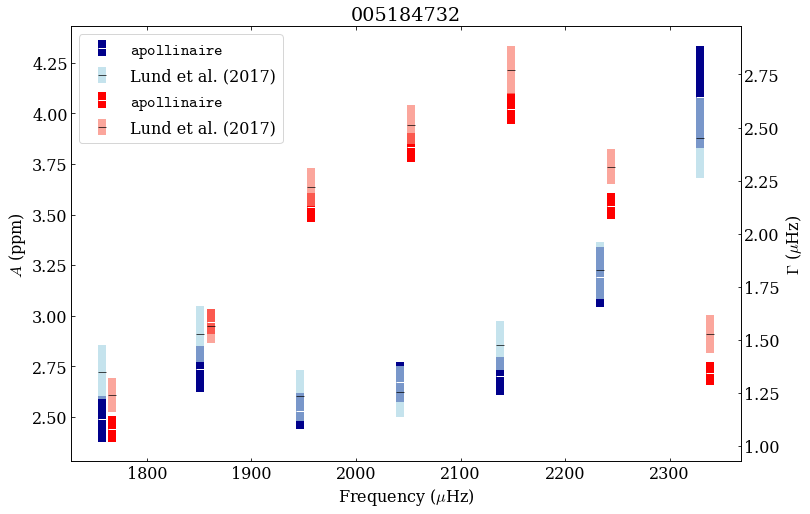

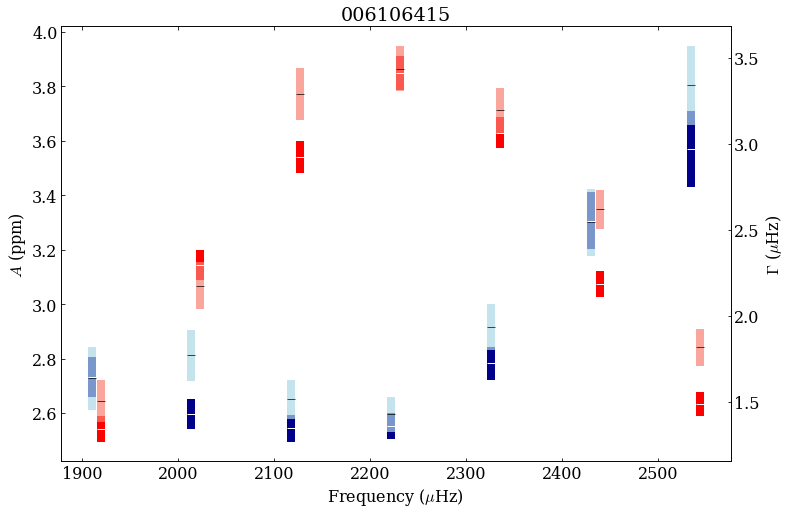

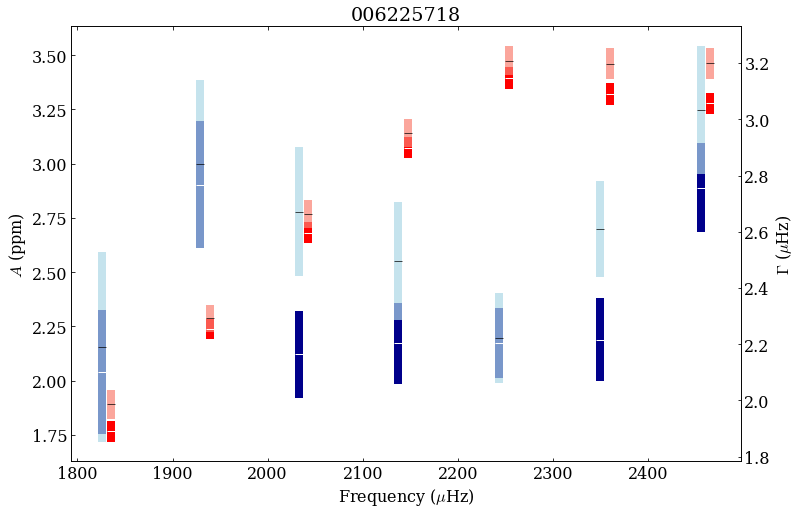

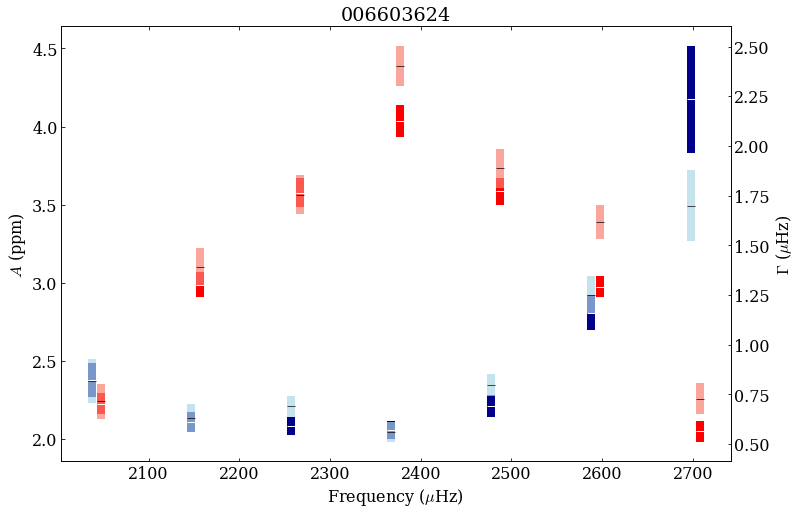

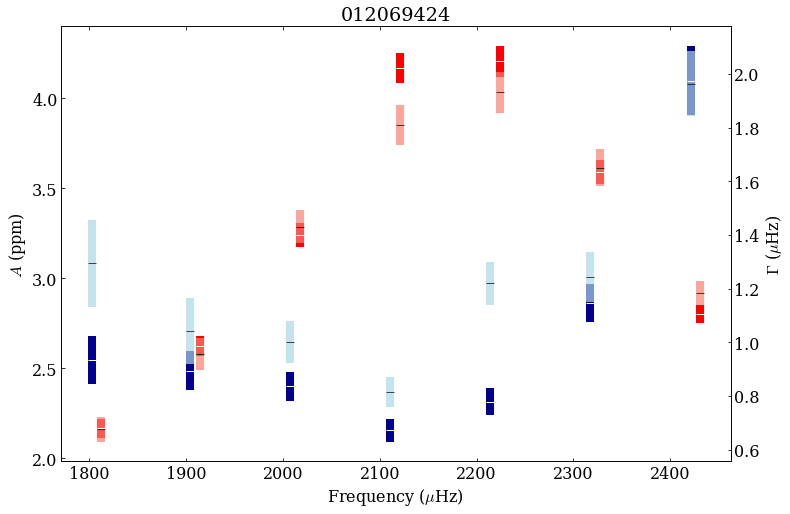

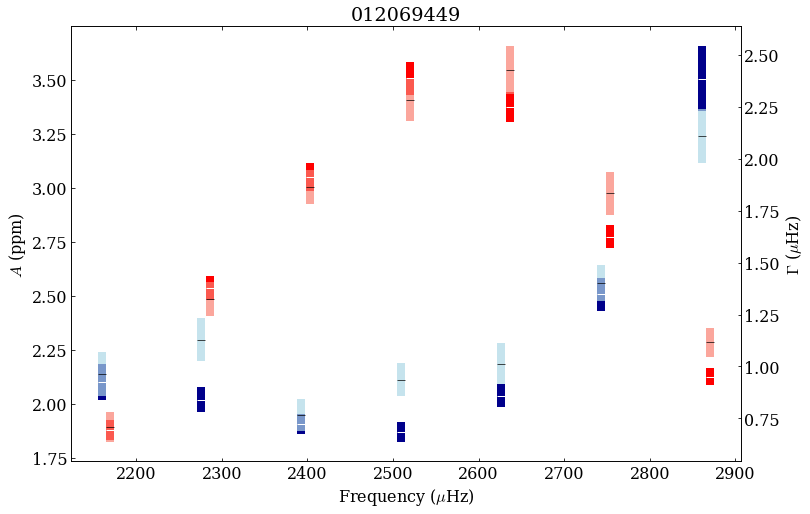

In [9]:
for kic in list_kic :

    df = hw_summary.loc[kic]
    
    figure, ax1 = plt.subplots (1, 1, figsize=(12, 8))
    
    ax = ax1.twinx ()
    elinewidth = 8
    markersize = 7.4
    e1 = ax.errorbar (df['Freq'], df[6], yerr=df[7], color='white', fmt=r'_',
                 capsize=None, elinewidth=elinewidth, markersize=markersize, ecolor='darkblue', label=r'$\mathtt{apollinaire}$')
    e2 = ax.errorbar (df['Freq'], df['Width'], yerr=df['e_Width'], color='black', fmt=r'_', 
                 capsize=None, elinewidth=elinewidth, alpha=0.7, markersize=markersize, ecolor='lightblue', label='Lund et al. (2017)')
    
    e3 = ax1.errorbar (df['Freq'] + 10, df['Amp_apn'], yerr=df['e_Amp_apn'], color='white', fmt=r'_',
                 capsize=None, elinewidth=elinewidth, markersize=markersize, ecolor='red', label=r'$\mathtt{apollinaire}$')
    e4 = ax1.errorbar (df['Freq'] + 10, df['Amp'], yerr=df['e_Amp'], color='black', fmt=r'_', 
                 capsize=None, elinewidth=elinewidth, alpha=0.7, markersize=markersize, ecolor='salmon', label='Lund et al. (2017)')
        

    if kic==5184732 :
        lines, labels = ax.get_legend_handles_labels()
        lines1, labels1 = ax1.get_legend_handles_labels()
        ax.legend (lines+lines1, labels+labels1, loc=2)
    
    ax.set_title (str(kic).zfill (9))
    ax1.set_xlabel (r'Frequency ($\mu$Hz)')
    ax.set_ylabel (r'$\Gamma$ ($\mu$Hz)')
    ax1.set_ylabel (r'$A$ (ppm)')
    
    figure.savefig (path.join ('plots', 'hw_' + str (kic).zfill (9) + '.pdf'), format='pdf')

In [10]:
f_latex = make_latex_freq (f_summary)

filename_tab_f = 'LaTex/stellar_freq.tex'
f = open (filename_tab_f, 'w')
f.write (f_latex)
f.close ()

hw_latex = make_latex_hw (hw_summary)

filename_tab_hw = 'LaTex/stellar_hw.tex'
f = open (filename_tab_hw, 'w')
f.write (hw_latex)
f.close ()


In [11]:
nmodes, total_one_sigma, total_three_sigma = 0, 0, 0
for kic in list_kic :
    # Width difference
    df = hw_summary.loc[kic]
    count_one_sigma = np.count_nonzero ((df['Width']<df[6]-df[7])|(df['Width']>df[6]+df[7]))
    count_three_sigma = np.count_nonzero ((df['Width']<df[6]-3*df[7])|(df['Width']>df[6]+3*df[7]))
    nmodes += df.index.size
    total_one_sigma += count_one_sigma
    total_three_sigma += count_three_sigma
    print ('KIC {}: {} fitted widths, {} beyond 1 sigma, {} beyond 3 sigma'.format (kic, df.index.size, 
                                                                count_one_sigma, count_three_sigma))
print ('Summary: {} fitted widths, {} beyond 1 sigma, {} beyond 3 sigma'.format (nmodes, 
                                                            total_one_sigma, total_three_sigma))

KIC 5184732: 7 fitted widths, 3 beyond 1 sigma, 0 beyond 3 sigma
KIC 6106415: 7 fitted widths, 4 beyond 1 sigma, 1 beyond 3 sigma
KIC 6225718: 7 fitted widths, 4 beyond 1 sigma, 1 beyond 3 sigma
KIC 6603624: 7 fitted widths, 4 beyond 1 sigma, 0 beyond 3 sigma
KIC 12069424: 7 fitted widths, 6 beyond 1 sigma, 4 beyond 3 sigma
KIC 12069449: 7 fitted widths, 4 beyond 1 sigma, 2 beyond 3 sigma
Summary: 42 fitted widths, 25 beyond 1 sigma, 8 beyond 3 sigma


In [12]:
nmodes, total_one_sigma, total_three_sigma = 0, 0, 0
for kic in list_kic :
    # Amp difference
    df = hw_summary.loc[kic]
    count_one_sigma = np.count_nonzero ((df['Amp']<df['Amp_apn']-df['e_Amp_apn'])|(df['Amp']>df['Amp_apn']+df['e_Amp_apn']))
    count_three_sigma = np.count_nonzero ((df['Amp']<df['Amp_apn']-3*df['e_Amp_apn'])|(df['Amp']>df['Amp_apn']+3*df['e_Amp_apn']))
    nmodes += df.index.size
    total_one_sigma += count_one_sigma
    total_three_sigma += count_three_sigma
    print ('KIC {}: {} fitted amplitudes, {} beyond 1 sigma, {} beyond 3 sigma'.format (kic, df.index.size, 
                                                                count_one_sigma, count_three_sigma))
print ('Summary: {} fitted amplitudes, {} beyond 1 sigma, {} beyond 3 sigma'.format (nmodes, 
                                                            total_one_sigma, total_three_sigma))

KIC 5184732: 7 fitted amplitudes, 6 beyond 1 sigma, 2 beyond 3 sigma
KIC 6106415: 7 fitted amplitudes, 6 beyond 1 sigma, 3 beyond 3 sigma
KIC 6225718: 7 fitted amplitudes, 7 beyond 1 sigma, 1 beyond 3 sigma
KIC 6603624: 7 fitted amplitudes, 5 beyond 1 sigma, 3 beyond 3 sigma
KIC 12069424: 7 fitted amplitudes, 3 beyond 1 sigma, 1 beyond 3 sigma
KIC 12069449: 7 fitted amplitudes, 4 beyond 1 sigma, 2 beyond 3 sigma
Summary: 42 fitted amplitudes, 31 beyond 1 sigma, 12 beyond 3 sigma
